In [1]:
import logging
import os
import torch
from torch.utils.data import DataLoader
from drcnet.data import DataSet
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from utils import setup_logging
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import visualize_single_volume
from utils.utils import load_config

train = False
dataset = "dbrain"
# Setup logging
log_file = setup_logging(log_level=logging.INFO)
logging.info(f"Starting training with dataset: {dataset}")

# Get the directory where this script is located
script_dir = "/home/paco/TechJourney/TechJourney/DWMRI/src/drcnet"
config_path = os.path.join(script_dir, "config.yaml")

logging.info(f"Loading config from: {config_path}")

settings = load_config(config_path)
logging.info("Configuration loaded successfully")

if dataset == "dbrain":
    logging.info("Using DBrain dataset configuration")
    settings = settings.dbrain
    data_loader = DBrainDataLoader(
        nii_path=settings.data.nii_path,
        bvecs_path=settings.data.bvecs_path,
        bvalue=settings.data.bvalue,
        noise_sigma=settings.data.noise_sigma,
    )
original_data, noisy_data = data_loader.load_data()
take_volumes = settings.data.num_b0s + settings.data.num_volumes
logging.info(
    f"Taking volumes from {settings.data.num_b0s} to {take_volumes}"
)
noisy_data = noisy_data[
    : settings.data.take_x,
    : settings.data.take_y,
    : settings.data.take_z,
    settings.data.num_b0s : take_volumes,
]


/home/paco/vqvae/env-torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-22 19:03:05,165 - root - INFO - Logging configured - level: INFO, file: logs/training_20250722_190305.log
2025-07-22 19:03:05,166 - root - INFO - Starting training with dataset: dbrain
2025-07-22 19:03:05,167 - root - INFO - Loading config from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-07-22 19:03:05,168 - root - INFO - Loading configuration from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-07-22 19:03:05,174 - root - INFO - Configuration file loaded successfully
2025-07-22 19:03:05,175 - root - INFO - Configuration converted to Munch object
2025-07-22 19:03:05,175 - root - INFO - Configuration loaded successfully
2025-07-22 19:03:05,176 - root - INFO - Using DBrain dat

(96, 10, 128, 128)


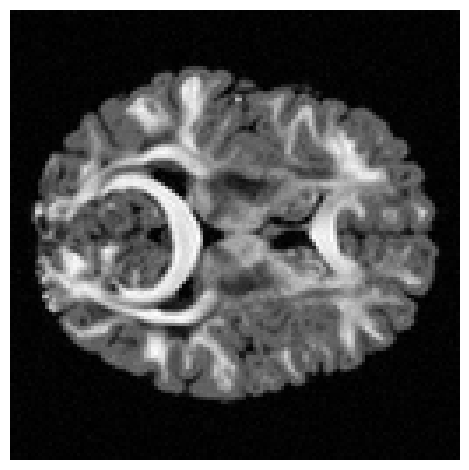

In [6]:
import numpy as np

visualize_single_volume(
                np.transpose(noisy_data, (2,3,0,1)),
            )

In [16]:
from utils.checkpoint import load_checkpoint

logging.info("Reconstructing DWIs...")
best_loss_checkpoint = os.path.join(
            checkpoint_dir, "best_loss_checkpoint.pth"
        )
reconstruct_model = DenoiserNet(
            input_channels=settings.model.in_channel,
            output_channels=settings.model.out_channel,
            groups=settings.model.groups,
            dense_convs=settings.model.dense_convs,
            residual=settings.model.residual,
            base_filters=settings.model.base_filters,
            output_shape=(
                settings.model.out_channel,
                settings.data.take_x,
                settings.data.take_y,
                settings.data.take_z,
            ),
            device=settings.train.device,
        )
reconstruct_model, _, _, _, _ = load_checkpoint(
            model=reconstruct_model,
            optimizer=optimizer,
            filename=best_loss_checkpoint,
            device=settings.reconstruct.device,
        )
reconstruct_noisy_data = noisy_data[:,:,:96,:]
noisy_data_shape = reconstruct_noisy_data.shape
reconstruct_set = DataSet(
            reconstruct_noisy_data,
            take_volume_idx=settings.data.take_volume_idx,
            patch_size=(
                settings.data.num_volumes,
                settings.data.take_x,
                settings.data.take_y,
                settings.data.take_z,
            ),
            step=1,
        )
reconstruct_loader = DataLoader(reconstruct_set, batch_size=1, shuffle=False)

2025-07-22 09:05:47,532 - root - INFO - Reconstructing DWIs...
2025-07-22 09:05:47,533 - root - INFO - Initializing DenoiserNet: input_channels=9, output_channels=1, groups=1, dense_convs=2, residual=True, base_filters=32
2025-07-22 09:05:47,536 - root - INFO - Initializing GatedBlock: x_channels=32, h_channels=32, dense_convs=2, groups=1
2025-07-22 09:05:47,537 - root - INFO - Initializing DenoisingBlock: in_channels=64, inner_channels=32, out_channels=32, inner_convolutions=2, residual=False
2025-07-22 09:05:47,538 - root - INFO - Initializing FactorizedBlock: in_channels=96, out_channels=32, groups=1
2025-07-22 09:05:47,540 - root - INFO - Initializing FactorizedBlock: in_channels=128, out_channels=32, groups=1
2025-07-22 09:05:47,575 - root - INFO - Attempting to load checkpoint from: drcnet/checkpoints/dbrain/bvalue_2500/num_volumes_10/noise_sigma_0.01/learning_rate_0.0001/best_loss_checkpoint.pth
2025-07-22 09:05:47,629 - root - INFO - Checkpoint loaded successfully: drcnet/check

In [23]:
from tqdm import tqdm

device = "cpu"
reconstruct_model.to(device)
reconstruct_model.eval()
with torch.inference_mode():
    for x, _ in tqdm(reconstruct_loader):
        x = x.to(device)
        reconstructed = reconstruct_model(x)
reconstructed = reconstructed.squeeze().detach().cpu().numpy()

    

100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


In [21]:
import numpy as np
reconstructed = np.transpose(reconstructed[None,...], (0,3,1,2))

In [3]:
from utils.metrics import visualize_single_volume

visualize_single_volume(
                 reconstructed,
                    slice_idx=10
)

NameError: name 'reconstructed' is not defined